# DSCI 619 Final Project
### Lauren Schmiedeler

## Part II

##### Load the required libraries.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf

##### Set a theme for the plots and increase the font size.

In [2]:
sns.set_theme()
sns.set(font_scale = 1.5)

##### Create a list that contains the names of the three models used.

In [3]:
models = ["Embedding + GRU", "Embedding + LSTM", "Embedding + GRU + LSTM"]

##### Create helper functions.

In [4]:
def plot_confusion_matrix(y_true, y_pred):
    cmap = sns.diverging_palette(h_neg = 220, h_pos = 50, l = 75, as_cmap = True)
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, normalize = "true")
    ax = sns.heatmap(cm, cmap = cmap, annot = True, fmt = ".2f")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix");

In [5]:
def plot_loss_and_accuracy(history):
    plt.figure(figsize = (16, 6))
    plt.subplot(1, 2, 1)
    train_history = pd.DataFrame(history.history)
    train_history["epoch"] = history.epoch
    sns.lineplot(x = "epoch", y = "loss", data = train_history, label = "Train Loss")
    sns.lineplot(x = "epoch", y = "val_loss", data = train_history, label = "Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss")
    plt.subplot(1, 2, 2)
    sns.lineplot(x = "epoch", y = "accuracy", data = train_history, label = "Train Accuracy")
    sns.lineplot(x = "epoch", y = "val_accuracy", data = train_history, label = "Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train and Validation Accuracy");

#### 1. Download the dataset that is about 25 KB from Kaggle into the local disk and unzip it.

In [6]:
reviews = pd.read_csv("Restaurant_Reviews.tsv", sep = "\t")
reviews

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


#### 2. Clean and preprocess the text data and split into training and test dataset.

##### Check for missing values before cleaning.

Before cleaning, there are no missing values.

In [7]:
print(reviews.isnull().sum())

Review    0
Liked     0
dtype: int64


##### Print out the first 10 reviews before cleaning.

In [8]:
print("Before Cleaning")
for i in range(10):
    print(f"Review {i + 1}: {reviews.Review[i]}")

Before Cleaning
Review 1: Wow... Loved this place.
Review 2: Crust is not good.
Review 3: Not tasty and the texture was just nasty.
Review 4: Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.
Review 5: The selection on the menu was great and so were the prices.
Review 6: Now I am getting angry and I want my damn pho.
Review 7: Honeslty it didn't taste THAT fresh.)
Review 8: The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.
Review 9: The fries were great too.
Review 10: A great touch.


##### Clean the review texts.

1. Remove non-alphanumeric and non-whitespace characters.
2. Remove extra spaces.
3. Convert to lowercase.

In [9]:
reviews["Review"] = reviews["Review"].apply(lambda x: re.sub(r"[^A-Za-z0-9\s]+", "", x))
reviews["Review"] = reviews["Review"].apply(lambda x: re.sub(r"\s+", " ", x))
reviews["Review"] = reviews["Review"].apply(lambda x: x.lower())

##### Print out the first 10 reviews after cleaning.

In [10]:
print("After Cleaning")
for i in range(10):
    print(f"Review {i + 1}: {reviews.Review[i]}")

After Cleaning
Review 1: wow loved this place
Review 2: crust is not good
Review 3: not tasty and the texture was just nasty
Review 4: stopped by during the late may bank holiday off rick steve recommendation and loved it
Review 5: the selection on the menu was great and so were the prices
Review 6: now i am getting angry and i want my damn pho
Review 7: honeslty it didnt taste that fresh
Review 8: the potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer
Review 9: the fries were great too
Review 10: a great touch


##### Check for missing values after cleaning.

After cleaning, there are still no missing values.

In [11]:
print(reviews.isnull().sum())

Review    0
Liked     0
dtype: int64


##### Check the label distribution.

This dataset is perfectly balanced.

In [12]:
reviews["Liked"].value_counts(normalize = True)

1    0.5
0    0.5
Name: Liked, dtype: float64

In [13]:
label_counts = pd.DataFrame(reviews["Liked"].value_counts())
label_counts["label"] = label_counts.index
label_counts.columns = ["count", "label"]

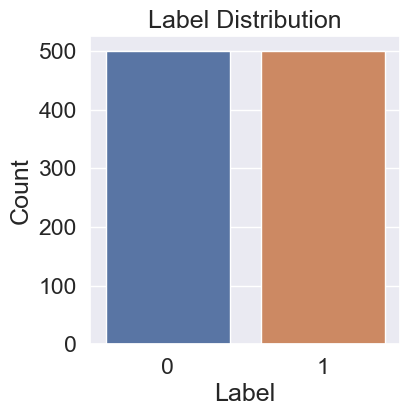

In [14]:
plt.figure(figsize = (4, 4))
sns.barplot(data = label_counts, x = "label", y = "count")
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Distribution");

##### Split the data into a training set (70% of the data) and a test set (30% of the data).

In [15]:
X = reviews["Review"].values
y = reviews["Liked"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 100)
print("X train shape =", X_train.shape)
print("X test shape =", X_test.shape)

X train shape = (700,)
X test shape = (300,)


#### 3. Build a baseline RNN model using embedding layer and GRU on the training dataset and evaluate it on the test dataset.

##### Build a baseline RNN model.

Use an embedding layer and a GRU layer.

In [16]:
# specify the vocab size
VOCAB_SIZE = 1000
# perform text vectorization
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens = VOCAB_SIZE, output_sequence_length = 20)
# fit the preprocessing layer to the training data
encoder.adapt(X_train)

In [17]:
model_1 = tf.keras.Sequential([
    # encoding (text vectorization) layer
    encoder, 
    # embedding layer
    tf.keras.layers.Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero = True),
    # GRU layer
    tf.keras.layers.GRU(64, dropout = 0.5, return_sequences = True),
    # convert output to 2D
    tf.keras.layers.Flatten(),
    # binary classification layers
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

In [18]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 20)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 20, 64)            64000     
                                                                 
 gru (GRU)                   (None, 20, 64)            24960     
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

##### Compile the model and train it on the training dataset.

In [19]:
%%time
# compile the model
model_1.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
# add early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 2)
# train the model
history_1 = model_1.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), batch_size = 32, epochs = 10, callbacks = [callback])

Epoch 1/10
22/22 [==============================] - 5s 69ms/step - loss: 0.6872 - accuracy: 0.5500 - val_loss: 0.6836 - val_accuracy: 0.5500
Epoch 2/10
22/22 [==============================] - 0s 16ms/step - loss: 0.5772 - accuracy: 0.7471 - val_loss: 0.5513 - val_accuracy: 0.6967
Epoch 3/10
22/22 [==============================] - 0s 17ms/step - loss: 0.3128 - accuracy: 0.8686 - val_loss: 0.4840 - val_accuracy: 0.7900
Epoch 4/10
22/22 [==============================] - 0s 18ms/step - loss: 0.1961 - accuracy: 0.9271 - val_loss: 0.5123 - val_accuracy: 0.8267
Epoch 5/10
22/22 [==============================] - 0s 19ms/step - loss: 0.1099 - accuracy: 0.9600 - val_loss: 0.5897 - val_accuracy: 0.8167
Epoch 6/10
22/22 [==============================] - 0s 18ms/step - loss: 0.1132 - accuracy: 0.9600 - val_loss: 0.6744 - val_accuracy: 0.7967
CPU times: total: 5.59 s
Wall time: 7.01 s


##### Make predictions on the test dataset using the model.

In [20]:
predictions_probs_1 = model_1.predict(X_test)
predictions_1 = np.asarray([1 if predictions_probs_1[i][0] > 0.5 else 0 for i in range(len(X_test))])

10/10 [==============================] - 1s 5ms/step


##### Evaluate the model by displaying its classification report.

In [21]:
print(classification_report(y_true = y_test, y_pred = predictions_1))

              precision    recall  f1-score   support

           0       0.73      0.95      0.82       150
           1       0.92      0.65      0.76       150

    accuracy                           0.80       300
   macro avg       0.83      0.80      0.79       300
weighted avg       0.83      0.80      0.79       300



##### Plot a confusion matrix for the model.

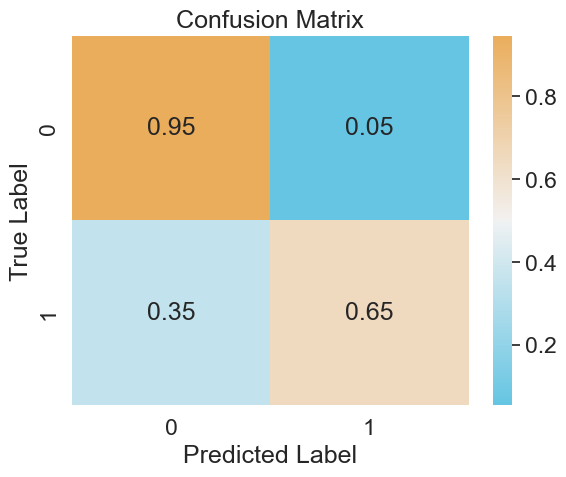

In [22]:
plot_confusion_matrix(y_test, predictions_1)

##### Plot the training and validation loss and accuracy for each epoch of training.

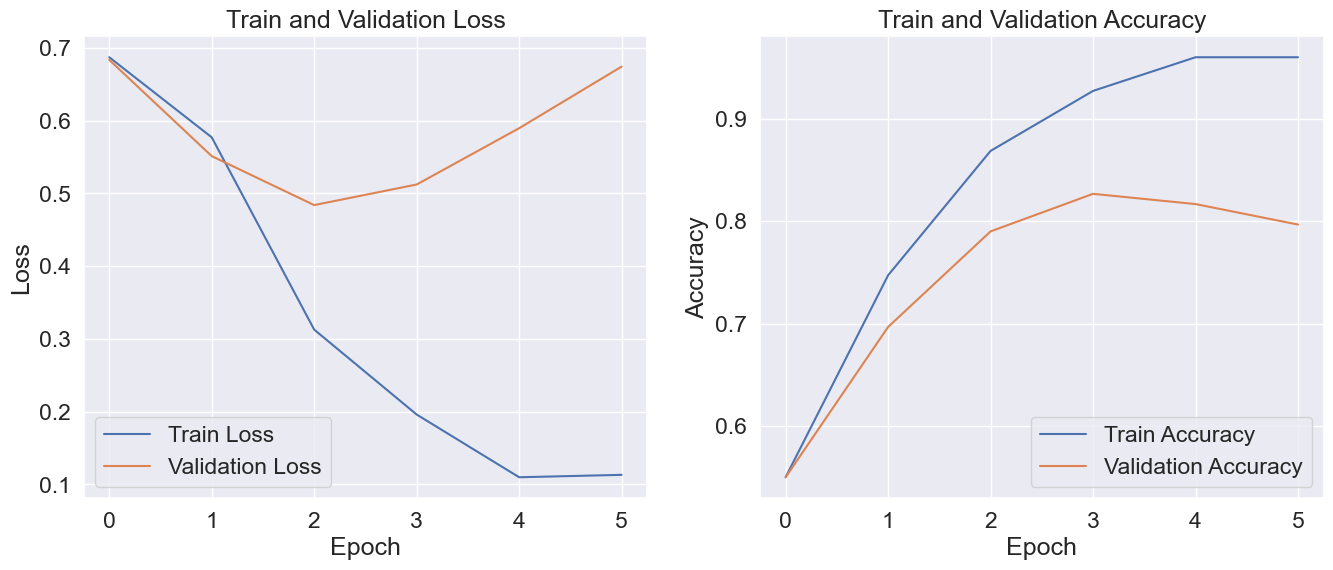

In [23]:
plot_loss_and_accuracy(history_1)

#### 4. Build a second RNN model using embedding layer and LSTM and evaluate it on the test dataset.

##### Build a second RNN model.

Use an embedding layer and an LSTM layer.

In [24]:
model_2 = tf.keras.Sequential([
    # encoding (text vectorization) layer
    encoder, 
    # embedding layer
    tf.keras.layers.Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero = True),
    # LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.5)),
    # binary classification layers
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

In [25]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 20)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 20, 64)            64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-tr

##### Compile the model and train it on the training dataset.

In [26]:
%%time
# compile the model
model_2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
# add early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 2)
# train the model
history_2 = model_2.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), batch_size = 32, epochs = 10, callbacks = [callback])

Epoch 1/10
22/22 [==============================] - 9s 127ms/step - loss: 0.6914 - accuracy: 0.5514 - val_loss: 0.6881 - val_accuracy: 0.5800
Epoch 2/10
22/22 [==============================] - 0s 21ms/step - loss: 0.6586 - accuracy: 0.7314 - val_loss: 0.6101 - val_accuracy: 0.7567
Epoch 3/10
22/22 [==============================] - 1s 24ms/step - loss: 0.4625 - accuracy: 0.8229 - val_loss: 0.5039 - val_accuracy: 0.7767
Epoch 4/10
22/22 [==============================] - 1s 25ms/step - loss: 0.2355 - accuracy: 0.9386 - val_loss: 0.5285 - val_accuracy: 0.8367
Epoch 5/10
22/22 [==============================] - 1s 25ms/step - loss: 0.1609 - accuracy: 0.9457 - val_loss: 0.4908 - val_accuracy: 0.8200
Epoch 6/10
22/22 [==============================] - 1s 26ms/step - loss: 0.1091 - accuracy: 0.9743 - val_loss: 0.5698 - val_accuracy: 0.7867
CPU times: total: 9.67 s
Wall time: 11.5 s


##### Make predictions on the test dataset using the model.

In [27]:
predictions_probs_2 = model_2.predict(X_test)
predictions_2 = np.asarray([1 if predictions_probs_2[i][0] > 0.5 else 0 for i in range(len(X_test))])

10/10 [==============================] - 2s 6ms/step


##### Evaluate the model by displaying its classification report.

In [28]:
print(classification_report(y_true = y_test, y_pred = predictions_2))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       150
           1       0.76      0.83      0.80       150

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300



##### Plot a confusion matrix for the model.

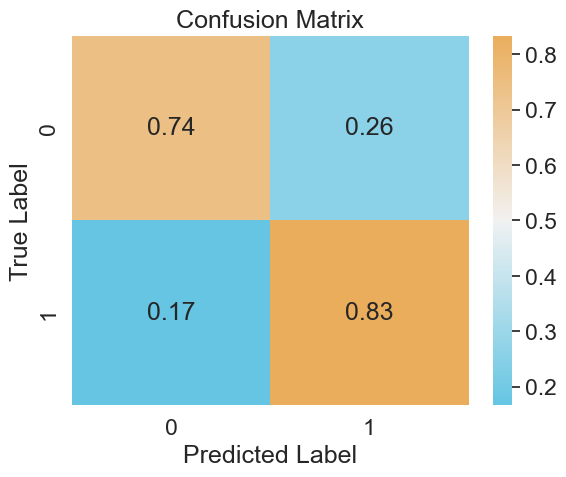

In [29]:
plot_confusion_matrix(y_test, predictions_2)

##### Plot the training and validation loss and accuracy for each epoch of training.

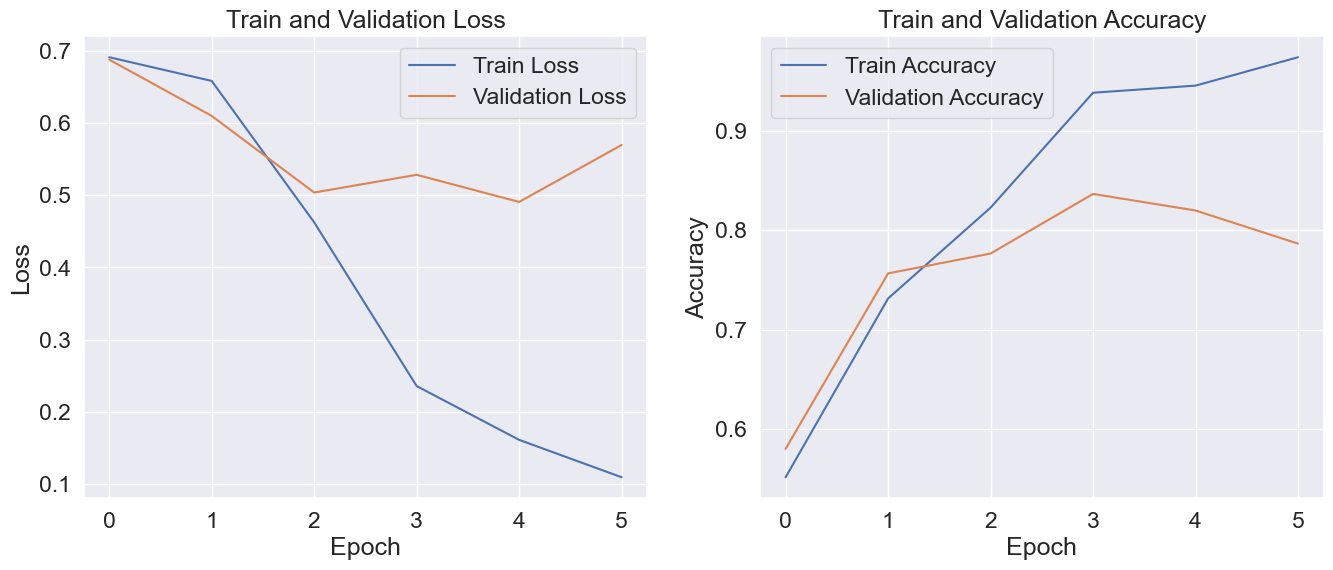

In [30]:
plot_loss_and_accuracy(history_2)

#### 5. Build a third RNN model using embedding layer and GRU and LSTM and evaluate it on the test dataset.

##### Build a third RNN model.

Use an embedding layer, a GRU layer, and an LSTM layer.

In [31]:
model_3 = tf.keras.Sequential([
    # encoding (text vectorization) layer
    encoder, 
    # embedding layer
    tf.keras.layers.Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero = True),
    # GRU layer
    tf.keras.layers.GRU(64, dropout = 0.5, return_sequences = True),
    # LSTM layer
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.5)),
    # binary classification layers
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

In [32]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 20)               0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 20, 64)            64000     
                                                                 
 gru_1 (GRU)                 (None, 20, 64)            24960     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                

##### Compile the model and train it on the training dataset.

In [33]:
%%time
# compile the model
model_3.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
# add early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 2)
# train the model
history_3 = model_3.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), batch_size = 32, epochs = 10, callbacks = [callback])

Epoch 1/10
22/22 [==============================] - 15s 210ms/step - loss: 0.6918 - accuracy: 0.5100 - val_loss: 0.6900 - val_accuracy: 0.5067
Epoch 2/10
22/22 [==============================] - 1s 37ms/step - loss: 0.6448 - accuracy: 0.6543 - val_loss: 0.5930 - val_accuracy: 0.7000
Epoch 3/10
22/22 [==============================] - 1s 39ms/step - loss: 0.4871 - accuracy: 0.8071 - val_loss: 0.5310 - val_accuracy: 0.7367
Epoch 4/10
22/22 [==============================] - 1s 37ms/step - loss: 0.2983 - accuracy: 0.8914 - val_loss: 0.5590 - val_accuracy: 0.8067
Epoch 5/10
22/22 [==============================] - 1s 38ms/step - loss: 0.2013 - accuracy: 0.9229 - val_loss: 0.6666 - val_accuracy: 0.7900
Epoch 6/10
22/22 [==============================] - 1s 38ms/step - loss: 0.1794 - accuracy: 0.9329 - val_loss: 0.5662 - val_accuracy: 0.8133
Epoch 7/10
22/22 [==============================] - 1s 38ms/step - loss: 0.1251 - accuracy: 0.9529 - val_loss: 0.5022 - val_accuracy: 0.8200
Epoch 8/10


##### Make predictions on the test dataset using the model.

In [34]:
predictions_probs_3 = model_3.predict(X_test)
predictions_3 = np.asarray([1 if predictions_probs_3[i][0] > 0.5 else 0 for i in range(len(X_test))])

10/10 [==============================] - 3s 8ms/step


##### Evaluate the model by displaying its classification report.

In [35]:
print(classification_report(y_true = y_test, y_pred = predictions_3))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84       150
           1       0.91      0.71      0.80       150

    accuracy                           0.82       300
   macro avg       0.84      0.82      0.82       300
weighted avg       0.84      0.82      0.82       300



##### Plot a confusion matrix for the model.

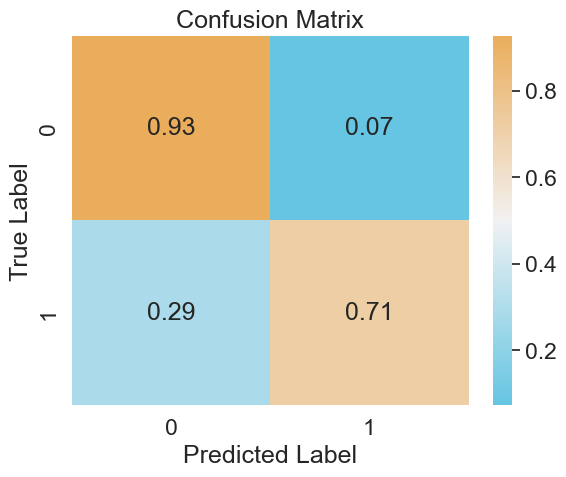

In [36]:
plot_confusion_matrix(y_test, predictions_3)

##### Plot the training and validation loss and accuracy for each epoch of training.

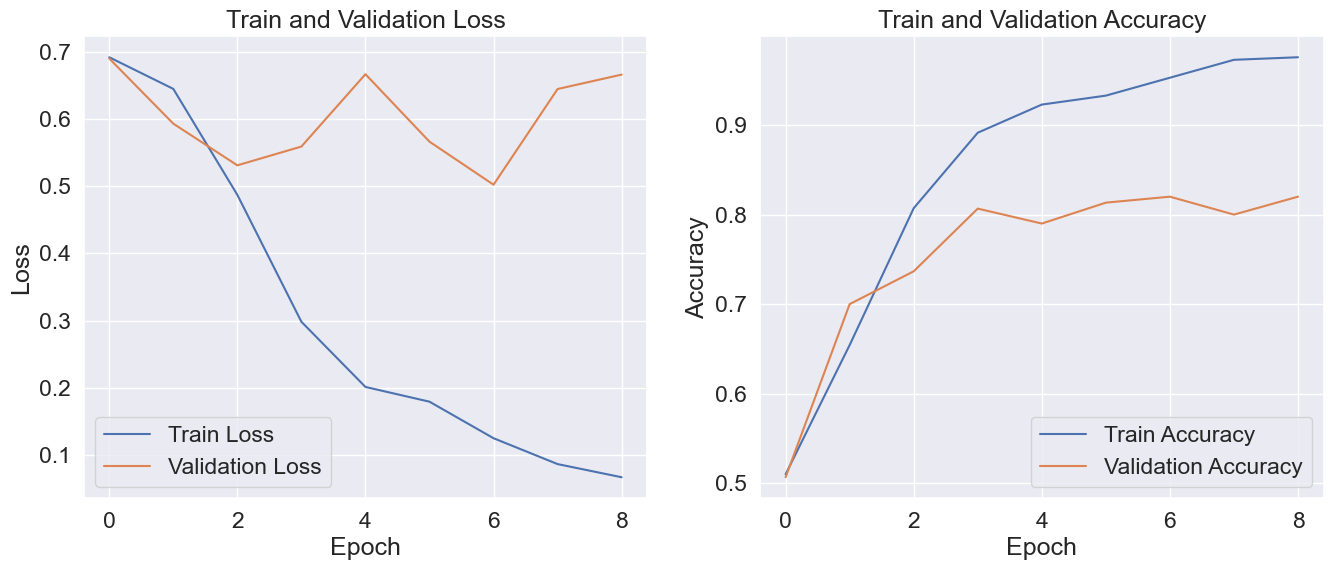

In [37]:
plot_loss_and_accuracy(history_3)

#### 6. Which model do you recommend for the model in Q3, Q4, and Q5? Justify your answer.
+ All three models have similar overall accuracies and f1-scores and overfit the data.
+ However, I would recommend the second model (RNN with Embedding and LSTM) because its precision and recall are closer in value than the precisions and recalls for the other two models while its accuracy and f1-score are about the same as those for the other two models.
    + The difference between the accuracy for "liked" (label = 1) reviews and the accuracy for "did not like" (label = 0) reviews is smaller for the second model than for the other two models.

##### Create a dataframe with the test metrics for each model:
+ accuracy
+ precision
+ recall
+ f1

In [38]:
predictions = [predictions_1, predictions_2, predictions_3]
test_metrics = pd.DataFrame(columns = ["model", "accuracy", "precision", "recall", "f1"])
for i in range(len(models)):
    test_metrics = pd.concat([test_metrics, 
                              pd.DataFrame({"model": [models[i]],
                                            "accuracy": round(accuracy_score(y_true = y_test, y_pred = predictions[i]), 4),
                                            "precision": round(precision_score(y_true = y_test, y_pred = predictions[i]), 4),
                                            "recall": round(recall_score(y_true = y_test, y_pred = predictions[i]), 4),
                                            "f1": round(f1_score(y_true = y_test, y_pred = predictions[i]), 4)})])
test_metrics = test_metrics.reset_index(drop = True)

In [39]:
test_metrics

,model,accuracy,precision,recall,f1
0,Embedding + GRU,0.7967,0.9238,0.6467,0.7608
1,Embedding + LSTM,0.7867,0.7622,0.8333,0.7962
2,Embedding + GRU + LSTM,0.8200,0.9068,0.7133,0.7985


##### Create a dataframe with the test metrics by label for each model:
+ accuracy
+ f1

In [40]:
test_metrics_by_label = pd.DataFrame(columns = ["model", "label", "accuracy", "f1"])
for i in range(len(models)):
    cm = confusion_matrix(y_true = y_test, y_pred = predictions[i])
    accuracies = list(cm.diagonal() / cm.sum(axis = 1))
    cr = classification_report(y_true = y_test, y_pred = predictions[i], output_dict = True)
    for label in [0, 1]:
        test_metrics_by_label = pd.concat([test_metrics_by_label,
                                           pd.DataFrame({"model": [models[i]], "label": [label], 
                                                         "accuracy": round(accuracies[label], 4),
                                                         "f1": round(cr[str(label)]["f1-score"], 4)})])
test_metrics_by_label = test_metrics_by_label.reset_index(drop = True)

In [41]:
test_metrics_by_label

,model,label,accuracy,f1
0,Embedding + GRU,0,0.9467,0.8232
1,Embedding + GRU,1,0.6467,0.7608
2,Embedding + LSTM,0,0.7400,0.7762
3,Embedding + LSTM,1,0.8333,0.7962
4,Embedding + GRU + LSTM,0,0.9267,0.8373
5,Embedding + GRU + LSTM,1,0.7133,0.7985
